# PROJECT : FACE EXPRESSION RECOGNITION USING PYTORCH

In this project we are required to have in depth knowledge on convulational neural network and optimization algorithm  such as gradient descent , adam optimizer.

In [217]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

# LOADING DATASET

In [218]:
train_dataset_path ='/kaggle/input/face-expression-recognition-dataset/images/train'
valid_dataset_path = '/kaggle/input/face-expression-recognition-dataset/images/validation'

1. **iteration** is whenever network weights are updated in a neural newtork
2. **Epoch** is when network has seen whole dataset.Always apply multiple number of epochs to increase accuracy.Length of Epoch may vary a lot depending on complexity of dataset and as an estimate for beginner it ranges between 5 to 40. Some epochs take seconds some hours.Independant metric from Batch Size.
3. **Batch Size** used when epoch size is way to large for our ram so to shorten it we divide iterations under epoch into small batch.


In [219]:
LR = 0.001
EPOCHS = 15
BATCH_SIZE = 32


DEVICE = 'cuda'
#CUDA® is a parallel computing platform and programming model developed by NVIDIA for general computing on graphical processing units (GPUs). With CUDA, developers are able to dramatically speed up computing applications by harnessing the power of GPUs.
MODEL_NAME = 'efficientnet_b0'



In [220]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T 


In [221]:
train_augs = T.Compose([T.RandomHorizontalFlip(p = 0.5),T.RandomRotation(degrees = (-20,+20)),T.ToTensor()])
#To tensor in pytorch converts image from numpy or PIL into pytorch tensors also it will convert (h,w,c)->(c,h,w)
valid_augs = T.Compose([T.ToTensor()])


**Data Augmnetation** is done to avoid overfitiing. This is done by generating new sample of already existing data . like let's say we have only 1 image in our data set fliping and inverting the image makes 3 images of the same image. when this will be done on a larger scale it will improve our results drastically.

In [222]:
trainset = ImageFolder(train_dataset_path,transform = train_augs)
validset = ImageFolder(valid_dataset_path,transform = valid_augs)

In [223]:
len(trainset)

28821

In [224]:
len(validset)

7066

Text(0.5, 1.0, '0')

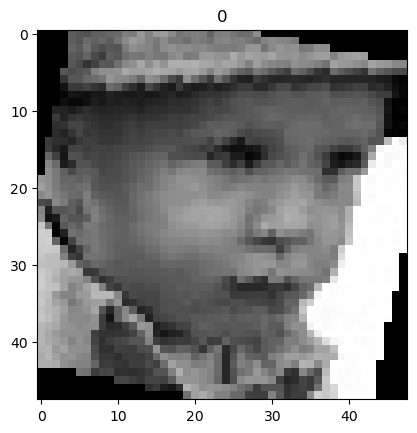

In [225]:
image , label = trainset[20]
plt.imshow(image.permute(1,2,0)) #(c,h,w)->(h,w,c)c at 0,h at 1 and w at 2
plt.title(label)

In [226]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '3')

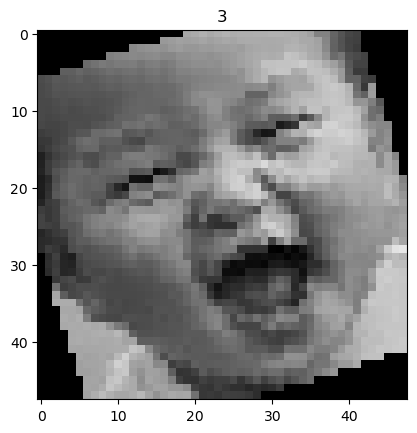

In [227]:
image , label = trainset[10000]
plt.imshow(image.permute(1,2,0)) #(c,h,w)->(h,w,c)c at 0,h at 1 and w at 2
plt.title(label)

Text(0.5, 1.0, '2')

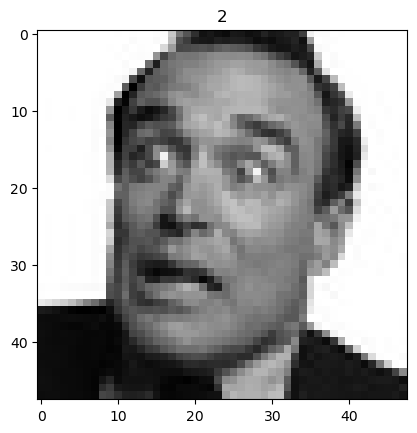

In [228]:
image , label = validset[2000]
plt.imshow(image.permute(1,2,0)) #(c,h,w)->(h,w,c)c at 0,h at 1 and w at 2
plt.title(label)

In [229]:
print(validset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


# LOAD DATASET INTO SMALL BATCHES

In [230]:
from torch.utils.data import DataLoader

In [231]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset,batch_size=BATCH_SIZE)

In [232]:
len(trainloader) #total number of batches in trainset

901

In [233]:
len(validloader) #totla number of batches in validset

221

In [234]:
for images,labels in trainloader:
    break;
print(f"one images of batch shape {images.shape}")#[32 -> batch size, 3->labels , 48->height,48 -> width]
print(f"one label batch shape {labels.shape}")

one images of batch shape torch.Size([32, 3, 48, 48])
one label batch shape torch.Size([32])


# CREATE MODEL

In [235]:
import timm 
from torch import nn 

In [236]:
class FaceModel(nn.Module):
    def __init__(self):
        super(FaceModel,self).__init__()
        self.eff_net = timm.create_model('resnet34',pretrained = True,num_classes = 7)
    def forward(self,images,labels = None):
        logits = self.eff_net(images)
        if labels != None:
            loss = nn.CrossEntropyLoss()(logits,labels)
            return logits,loss
        return logits
        

In [237]:
model = FaceModel()
model.to(DEVICE);

# CREATE TRAIN AND EVAL

In [238]:
from tqdm import tqdm

In [239]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [240]:
def train_fn(model,dataloader,optimizer,current_epo):
    model.train()
    total_loss = 0.0
    total_acc = 0.0 
    tk = tqdm(dataloader,desc = "EPOCHS" + "[TRAIN]" + str(current_epo+1) + "/"+ str(EPOCHS))
    for t,data in enumerate(tk):
        images,labels = data
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits,loss = model(images,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits,labels)
        tk.set_postfix({'loss':'%6f' %float(total_loss/(t+1)),'acc':'%6f' %float(total_acc/(t+1))})
    return total_loss/len(dataloader),total_acc/len(dataloader)

In [241]:
def eval_fn(model,dataloader,current_epo):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0 
    tk = tqdm(dataloader,desc = "EPOCH" + "[VALID]" + str(current_epo + 1) + "/"+ str(EPOCHS))
    for t,data in enumerate(tk):
        images,labels = data
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        
        
        logits,loss = model(images,labels)
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits,labels)
        tk.set_postfix({'loss':'%6f' %float(total_loss/(t+1)),'acc':'%6f' %float(total_acc/(t+1))})
    return total_loss/len(dataloader),total_acc/len(dataloader)

# CREATING TRAINING LOOP

In [242]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)



In [243]:
best_valid_loss= np.inf
for i in range(EPOCHS):
    train_loss,train_acc = train_fn(model,trainloader,optimizer,i)
    eval_loss,eval_acc = eval_fn(model,validloader,i)
    if eval_loss < best_valid_loss:
        torch.save(model.state_dict(),'best-weights.pt')
        print("Saved Best Valid Loss")
        best_valid_loss = eval_loss

EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:08<00:00, 25.66it/s, loss=1.231782, acc=0.533784]


Saved Best Valid Loss


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:08<00:00, 24.69it/s, loss=1.148616, acc=0.560368]


Saved Best Valid Loss


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:10<00:00, 21.96it/s, loss=1.101788, acc=0.579457]


Saved Best Valid Loss


EPOCH[VALID]6/15: 100%|██████████| 221/221 [00:08<00:00, 25.24it/s, loss=1.042069, acc=0.610109]


Saved Best Valid Loss


EPOCH[VALID]7/15: 100%|██████████| 221/221 [00:08<00:00, 25.94it/s, loss=1.000685, acc=0.630536]


Saved Best Valid Loss


EPOCH[VALID]11/15: 100%|██████████| 221/221 [00:08<00:00, 26.02it/s, loss=0.993816, acc=0.637987]


Saved Best Valid Loss


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:10<00:00, 21.84it/s, loss=1.053629, acc=0.638977]


In [244]:
best_valid_loss

0.9938163233423665

In [246]:
eval_acc*100

tensor(63.8977)